In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
import matplotlib as mpl

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [6]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")

In [7]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'Locus tag_x', 'Protein accession_x', 'Name_x', 'Symbol_x', 'Locus tag_y', 'Protein accession_y', 'Name_y', 'Symbol_y', 'Locus tag', 'Protein accession', 'Name', 'Symbol'
    uns: 'BacSC_params', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp

In [12]:
figure_path = "concept_fig"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [ ]:
plt.figure(figsize=(8, 6))
data_heatmap = pd.DataFrame(data_gene.X, index=data_gene.obs_names, columns=data_gene.var_names)
data_heatmap["ct"] = data_gene.obs["leiden_opt"]
data_heatmap = data_heatmap.sort_values("ct")
data_heatmap = data_heatmap.drop(columns="ct")

sns.heatmap(data_heatmap, cmap="magma", cbar_kws={'label': 'Variance-stabilized counts'})
plt.yticks([], [])
plt.xlabel("Genes")
plt.ylabel("Cells")
# plt.title("Variance-stabilized counts")

plt.tight_layout()
plt.savefig(figure_path + "/vst_heatmap.png", format="png", bbox_inches='tight', dpi=300)

plt.show()

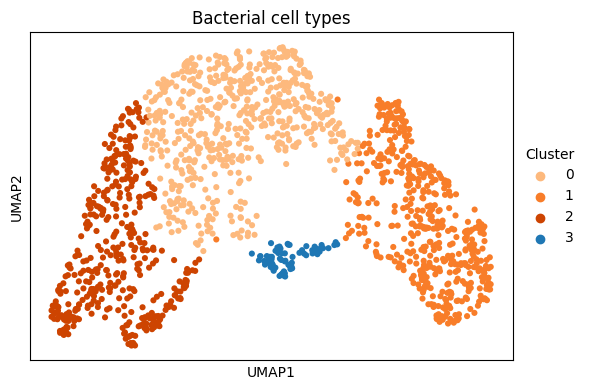

In [15]:
with plt.rc_context({"figure.figsize": (6, 4)}):
    
    colors = mpl.colormaps['Oranges'](np.linspace(0, 1, 10))
    fig = sc.pl.umap(data_gene, color="leiden_opt", palette=[colors[3], colors[5], colors[7], "tab:blue"], title="Bacterial cell types", show=False)
    ax = fig.axes
    ax.legend_.set_title("Cluster")
    plt.tight_layout()
    
    plt.savefig(figure_path + "/umap_clusters.png", format="png", bbox_inches='tight', dpi=300)
    
    plt.show()

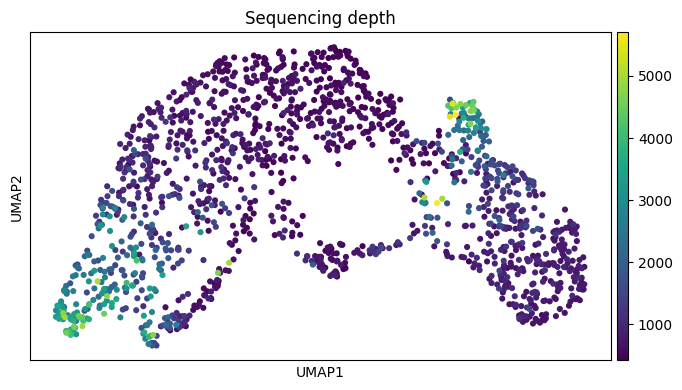

In [17]:
with plt.rc_context({"figure.figsize": (7, 4)}):

    fig = sc.pl.umap(data_gene, color="total_counts", alpha=1, show=False, title="Sequencing depth", cmap="viridis")
    ax = fig.axes
    
    
    plt.tight_layout()
    plt.savefig(figure_path + "/umap_seqdepth.png", format="png", bbox_inches='tight', dpi=300)
    plt.show()

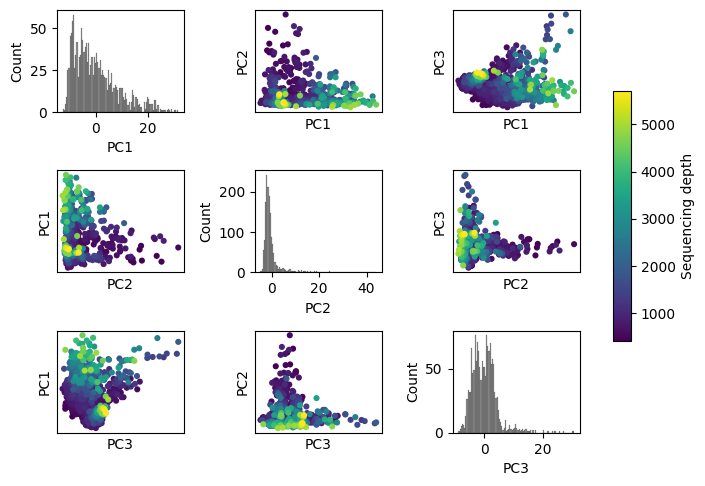

In [20]:
pca_df = pd.DataFrame(data_gene.obsm["X_pca"], index=data_gene.obs_names)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 5))
cbar_ax = fig.add_axes([1.03, .3, .03, .5])

sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(0,1), ax=ax[0, 1], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(1, 0), ax=ax[1,0], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(1,2), ax=ax[1,2], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(2,1), ax=ax[2,1], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(0,2), ax=ax[0,2], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(2,0), ax=ax[2,0], title="", show=False, colorbar_loc=None)

sns.histplot(pca_df, x=0, ax=ax[0,0], color="dimgrey", bins=100)
ax[0,0].set(xlabel="PC1")
sns.histplot(pca_df, x=1, ax=ax[1,1], color="dimgrey", bins=100)
ax[1,1].set(xlabel="PC2")
sns.histplot(pca_df, x=2, ax=ax[2,2], color="dimgrey", bins=100)
ax[2,2].set(xlabel="PC3")

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(np.min(data_gene.obs["total_counts"]), np.max(data_gene.obs["total_counts"]))  # or vmin, vmax
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm, cmap), cbar_ax)
cbar.set_label('Sequencing depth')

plt.tight_layout()
plt.savefig(figure_path + "/pca.png", format="png", bbox_inches='tight', dpi=300)

plt.show()

In [22]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")

data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")



Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

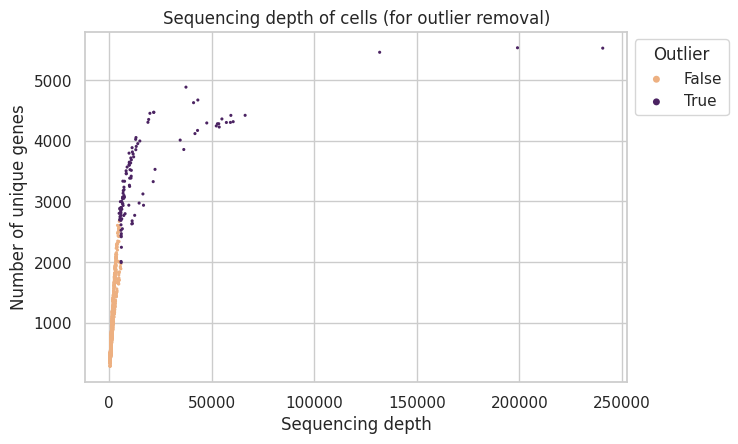

In [40]:
sns.set_theme(style="whitegrid")
data_maxpool.obs["outlier_cat"] = pd.Categorical(data_maxpool.obs["outlier"])
g = sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier_cat", show=False, size=20, title="Sequencing depth of cells (for outlier removal)", palette="flare")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
lgnd = g.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Outlier")
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
plt.tight_layout()
plt.savefig(figure_path + "/outliers.png", format="png", bbox_inches='tight', dpi=300)

plt.show()